Changelog:
* v1: test 3 differnet networks in projection space

* v2: test those networks in reconstructed space

* v3: test input (tot .* mu-map) instead

* v4: test input mumap and tot separately

* v5: 
    1. test resnet
    2. test sphere phantom
    3. move liver phantom from test set to training set
    4. add more training data
    
v6: test cnn with training dataset 1

v7: test training cnn with dataset 1 but without mumap

v8: test training cnn with training dataset 2

v9 (current version): training cnn with both training dataset 1 & 2 and mu-map


# Notebook: Deep Learning for Y90 SPECT Scatter Estimation

### Measurement Model

$$Y_i \approx Poisson(\sum_{j=1}^J a_{i,j} x_i + s_i)$$

$Y_i$ denotes the number of counts measured in the ith detector pixel.

$a_{i,j}$ denotes elements of the system matrix $A$ that models effects of depth-dependent attenuation and collimator/detector blur for a photon leaving the $j$th voxel toward the $i$th detector pixel.

$x = (x_1,...,x_j)$ denotes vector of unknown Y90 activity voxel values. 

$s_i$ denotes the scatter ‘contamination’ component for the $i$th detector pixel.



### Previous work for Y90 SPECT scatter correction [1]

Itertively estimate scatter based on SIMIND simulation

[1]Dewaraja, Yuni K., et al. "Improved quantitative 90Y bremsstrahlung SPECT/CT reconstruction with Monte Carlo scatter modeling." Medical physics 44.12 (2017): 6364-6376.

### Previous work for Y90 SPECT scatter correction [1]

Itertively estimate scatter based on SIMIND simulation

[1]Dewaraja, Yuni K., et al. "Improved quantitative 90Y bremsstrahlung SPECT/CT reconstruction with Monte Carlo scatter modeling." Medical physics 44.12 (2017): 6364-6376.

## Import necessary libraries

In [13]:
### IMPORT LIBRARIES ###
import scipy.io as sio
import numpy as np
import keras

from __future__ import print_function

# import cv2
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout, Conv2D, Dense, concatenate
from keras.optimizers import Adam, Nadam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

from skimage.transform import rotate, resize
# from skimage import data
import matplotlib.pyplot as plt
import glob
from keras.layers import BatchNormalization
from keras.layers.core import Activation, Layer
from keras.utils.vis_utils import plot_model
%matplotlib inline 

## Define global variables

In [14]:
### Define Global variables ###
SCALE_CONSTANT = 1000000
IND_NOR = True
Nx = 128 # size of x axis
Ny_sim = 128 # size of y axis for simind
Ny_mea = 80# size of y axis for measurement
Np = 128 # number of projections
Np_60 = 60
Ny_cat = 160
# N = 100

## Load training/test data

In [15]:
""" Load Data """
training_file_names = glob.glob('./training_data/s*_cat128*.mat')
training_file60 = glob.glob('./training_data/cat60*.mat')
test_file_names = glob.glob('./test_data/cat*.mat')
N_train = len(training_file_names)
N_train60 = len(training_file60)
N_test = len(test_file_names)
training_data = []
test_data = []
# training_tot = np.zeros((Nx,Ny_sim,Np,N_train)) # For non-concat version
training_tot = np.zeros((Nx,Ny_mea,Np,N_train)) # For concat version
training_pri = np.zeros((Nx,Ny_sim,Np,N_train))
training_sca = np.zeros((Nx,Ny_sim,Np,N_train))
training_mu = np.zeros((Nx,Ny_mea,Np,N_train))
# test_tot = np.zeros((Nx,Ny_mea,Np,N_test)) # For non-concat version
test_tot = np.zeros((Nx,Ny_mea,Np,N_test)) # For concat version
test_pri = np.zeros((Nx,Ny_mea,Np,N_test))
test_sca = np.zeros((Nx,Ny_mea,Np,N_test))
test_mu = np.zeros((Nx,Ny_mea,Np,N_test))

k = 0
print('---training data loading---')
for training_file_name in training_file_names:
    data = sio.loadmat(training_file_name)
#     tot = np.array(data['tot'])
    concat = np.array(data['concat'])
    pri = np.array(data['pri'])
    sca = np.array(data['sca'])
    training_tot[:,:,:,k] = concat[:,80:,:]
    training_pri[:,:,:,k] = pri
    training_sca[:,:,:,k] = sca
    training_mu[:,:,:,k] = concat[:,0:80,:]
    k += 1
    print(k,training_file_name)
print('---training data loaded---')
print('---training data shape: ',training_tot.shape,'---')
training_sca = training_sca[:,23:103,:,:]

k = 0
print('---test data loading---')
for test_file_name in test_file_names:
    data = sio.loadmat(test_file_name)
#     tot = np.array(data['tot'])
    concat = np.array(data['concat'])
    pri = np.array(data['pri'])
    sca = np.array(data['sca'])
    test_tot[:,:,:,k] = concat[:,80:,:]
    test_pri[:,:,:,k] = pri
    test_sca[:,:,:,k] = sca
    test_mu[:,:,:,k] = concat[:,0:80,:]
    k += 1
    print(k,test_file_name)
print('---test data loaded !---')
print('---test data shape: ',test_tot.shape,'---')

---training data loading---
1 ./training_data/s2_cat128_2rh_0823.mat
2 ./training_data/s2_cat128_th2_patient_w_noise_10272019.mat
3 ./training_data/s1_cat128_kl_patient_w_noise_v2_080519.mat
4 ./training_data/s1_cat128_sphere_w_noise_v2_080519.mat
5 ./training_data/s2_cat128_th1_patient_w_noise_10272019.mat
6 ./training_data/s1_cat128_kl_make_up_w_noise_v2_080519.mat
7 ./training_data/s2_cat128_xcat_0823.mat
8 ./training_data/s1_cat128_wb_w_noise_v2_080519.mat
---training data loaded---
---training data shape:  (128, 80, 128, 8) ---
---test data loading---
1 ./test_data/cat_liver_measure_w_noise_0826.mat
2 ./test_data/cat_shell_measure_Aug2019.mat
3 ./test_data/cat_shell2_measure_08202019.mat
4 ./test_data/cat_ch_0823.mat
5 ./test_data/cat_nema_w_noise_Apr2019.mat
6 ./test_data/cat_liver_w_noise_Apr2019.mat
7 ./test_data/cat_cali_measure_0822.mat
8 ./test_data/cat_ab2_v2_080519.mat
---test data loaded !---
---test data shape:  (128, 80, 128, 8) ---


## Scale training/test data to make simulated and measured data consistant

In [16]:
# training_tot_prod = training_tot[:,0:80,:,:]*training_tot[:,80:,:,:] 
# test_tot_prod = test_tot[:,0:80,:,:]*test_tot[:,80:,:,:] 

# print('training tot shape:',training_prod.shape)
print('training sca shape:',training_sca.shape)
# print('test tot shape',test_tot_prod.shape)
print('test sca shape',test_sca.shape)

""" Scale projections to keep measurement and simind in the same domain """
training_tot_nor = np.zeros(training_tot.shape)
training_sca_nor = np.zeros(training_sca.shape)
training_mu_nor = np.zeros(training_mu.shape)
test_tot_nor = np.zeros(test_tot.shape)
test_sca_nor = np.zeros(test_sca.shape)
test_mu_nor = np.zeros(test_mu.shape)

for i in range(training_tot.shape[3]):
    training_sca_nor[:,:,:,i] = training_sca[:,:,:,i] * SCALE_CONSTANT / np.sum(training_tot[:,:,:,i])
    training_tot_nor[:,:,:,i] = training_tot[:,:,:,i] * SCALE_CONSTANT / np.sum(training_tot[:,:,:,i])
#     training_mu_nor[:,:,:,i] = training_mu[:,:,:,i] * SCALE_CONSTANT / np.sum(training_mu[:,:,:,i])
    training_mu_nor[:,:,:,i] = training_mu[:,:,:,i]
for i in range(test_tot.shape[3]):
    test_sca_nor[:,:,:,i] = test_sca[:,:,:,i] * SCALE_CONSTANT / np.sum(test_sca[:,:,:,i]+test_pri[:,:,:,i])
    test_tot_nor[:,:,:,i] = test_tot[:,:,:,i] * SCALE_CONSTANT / np.sum(test_tot[:,:,:,i])
#     test_mu_nor[:,:,:,i] = test_mu[:,:,:,i] * SCALE_CONSTANT / np.sum(test_mu[:,:,:,i])
    test_mu_nor[:,:,:,i] = test_mu[:,:,:,i]
    
""" Define normalized and cutted data """
# training_tot_nor = training_tot_nor[:,23:103,:,:] # cut Ny to be 24:103 in matlab --> 23:103 in python
# training_sca_nor = training_sca_nor[:,23:103,:,:] #
# test_tot_nor = test_tot_nor
# test_sca_nor = test_sca_nor

""" Define normalized and cutted data """
print(np.sum(training_tot_nor))
training_prod = training_tot_nor * training_mu  #[:,23:103,:,:] # cut Ny to be 24:103 in matlab --> 23:103 in python
# training_sca_nor = training_sca_nor[:,23:103,:,:] #
print(np.sum(training_prod))
test_prod = test_tot_nor * test_mu
# test_sca_nor = test_sca_nor
# print(training_tot_prod.shape)
print(np.sum(training_sca_nor))
print(np.sum(training_tot_nor))
print(np.sum(test_sca_nor))
print(np.sum(test_tot_nor))
# print(training_sca_nor.shape)

training sca shape: (128, 80, 128, 8)
test sca shape (128, 80, 128, 8)


/Users/xianghaowei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


8000000.000000009
26377213.584909186
6790338.288642903
8000000.000000009
nan
8000000.0000000065


In [17]:
""" Randomly shuffle data and Split data """
# index = np.arange(img_N)
# np.random.shuffle(index)
# N = int(np.floor(0.8 * img_N))
# index_training = index[0:N]
# index_test = index[N:]
# training_tot = img_tot[:,:,index_training]
# training_sca = img_sca[:,:,index_training]
# test_tot = img_tot[:,:,index_test]
# test_sca = img_sca[:,:,index_test]


' Randomly shuffle data and Split data '

## Reshape training/test data

In [18]:


# training_tot_nor = np.zeros(training_tot.shape)
# training_sca_nor = np.zeros(training_sca.shape)
# test_tot_nor = np.zeros(test_tot.shape)
# test_sca_nor = np.zeros(test_sca.shape)

# """ Normalization """
# if IND_NOR == True:
#     for i in range(N):
#         training_tot_nor[:,:,i] = (training_tot[:,:,i] - np.mean(training_tot[:,:,i])) / np.std(training_tot[:,:,i])
#         training_sca_nor[:,:,i] = (training_sca[:,:,i] - np.mean(training_sca[:,:,i])) / np.std(training_sca[:,:,i])
#     for i in range(img_N - N):
#         test_tot_nor[:,:,i] = (test_tot[:,:,i] - np.mean(test_tot[:,:,i])) / np.std(test_tot[:,:,i])
#         test_sca_nor[:,:,i] = (test_sca[:,:,i] - np.mean(test_sca[:,:,i])) / np.std(test_sca[:,:,i])

""" save preprocessed data as numpy data """
# np.save('imgs_train.npy', training_tot)
# np.save('imgs_mask_train.npy', training_sca)
# np.save('imgs_test.npy', test_tot)
# np.save('imgs_id_test.npy', test_sca)

# training_tot_nor = training_tot_prod
# test_tot_nor = test_tot_prod

print(np.sum(training_tot_nor))
""" reshape input data to fit into CNN """
training_prod_nor = np.reshape(training_prod, [Nx,Ny_mea, training_tot.shape[3] * training_tot.shape[2] ,1])
training_prod_nor = np.transpose(training_prod_nor, [2,0,1,3])
print(np.sum(training_prod_nor))

training_tot_nor = np.reshape(training_tot_nor, [Nx,Ny_mea, training_tot.shape[3] * training_tot.shape[2] ,1])
training_tot_nor = np.transpose(training_tot_nor, [2,0,1,3])

training_sca_nor = np.reshape(training_sca_nor, [Nx,Ny_mea, training_tot.shape[3] * training_tot.shape[2] ,1])
training_sca_nor = np.transpose(training_sca_nor, [2,0,1,3])

training_mu_nor = np.reshape(training_mu_nor, [Nx,Ny_mea, training_tot.shape[3] * training_tot.shape[2] ,1])
training_mu_nor = np.transpose(training_mu_nor, [2,0,1,3])

test_prod_nor = np.reshape(test_prod, [Nx,Ny_mea, test_tot.shape[3] * test_tot.shape[2],1])
test_prod_nor = np.transpose(test_prod_nor, [2,0,1,3])

test_sca_nor = np.reshape(test_sca_nor, [Nx,Ny_mea, test_tot.shape[3] * test_tot.shape[2],1])
test_sca_nor = np.transpose(test_sca_nor, [2,0,1,3])

test_tot_nor = np.reshape(test_tot_nor, [Nx,Ny_mea, test_tot.shape[3] * test_tot.shape[2],1])
test_tot_nor = np.transpose(test_tot_nor, [2,0,1,3])

test_mu_nor = np.reshape(test_mu_nor, [Nx,Ny_mea, test_tot.shape[3] * test_tot.shape[2],1])
test_mu_nor = np.transpose(test_mu_nor, [2,0,1,3])

# Nt = img_tot_ab2.shape[2]
# tot_t = np.reshape(img_tot_wb, [img_rows,img_cols,Nt,1])
# tot_t = np.transpose(tot_t, [2,0,1,3])
# sca_t = np.reshape(img_sca_wb, [img_rows,img_cols,Nt,1])
# sca_t = np.transpose(sca_t, [2,0,1,3])

training_concat = np.concatenate((training_mu_nor, training_tot_nor), axis = 3)
test_concat = np.concatenate((test_mu_nor, test_tot_nor), axis = 3)


""" print data shape after preprocessing """
print('training data prod shape:', training_prod_nor.shape)
print('training data sca shape:', training_sca_nor.shape)
print('training tot shape:', training_tot_nor.shape)
print('training concat shape:', training_concat.shape)
print('training data mumap shape:', training_mu_nor.shape)

print('test data prod shape:', test_prod_nor.shape)
print('test data sca shape:', test_sca_nor.shape)
print('test data tot shape:', test_tot_nor.shape)
print('test data concat shape:', test_concat.shape)
print('test data mumap shape:', test_mu_nor.shape)

# print(np.sum(training_tot_nor))
# print(tot_t.shape)
# print(sca_t.shape)

8000000.000000009
26377213.584909186
training data prod shape: (1024, 128, 80, 1)
training data sca shape: (1024, 128, 80, 1)
training tot shape: (1024, 128, 80, 1)
training concat shape: (1024, 128, 80, 2)
training data mumap shape: (1024, 128, 80, 1)
test data prod shape: (1024, 128, 80, 1)
test data sca shape: (1024, 128, 80, 1)
test data tot shape: (1024, 128, 80, 1)
test data concat shape: (1024, 128, 80, 2)
test data mumap shape: (1024, 128, 80, 1)


## Scatter and Total projection preview

In [7]:
def plot_projection1(k = 400):
    """ Image Preview """
#     k =400 # look at kth image
    plt.style.use("default")
    fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(15, 10))
    im1 = ax1.imshow(np.transpose(training_sca_nor[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(training_tot_nor[k,:,:,0]))
    ax1.set_title('Scatter',fontsize = 20)
#     cbar = fig.colorbar(im1, shrink=0.55, ax=ax1)
    im2 = ax2.imshow(np.transpose(training_tot_nor[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(training_tot_nor[k,:,:,0]))
    ax2.set_title('Total', fontsize = 20)
#     cbar = fig.colorbar(im2, shrink=0.55, ax=ax2)
    im3 = ax3.imshow(np.transpose(training_mu_nor[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(training_concat[k,:,:,0]))
    ax3.set_title(' mumap', fontsize = 20)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.3])
    fig.colorbar(im2, cax=cbar_ax)
    print(np.sum(training_concat[:,:,:,0]))
    print(np.sum(training_tot_nor))

8232838.524235271
4000000.0000000033


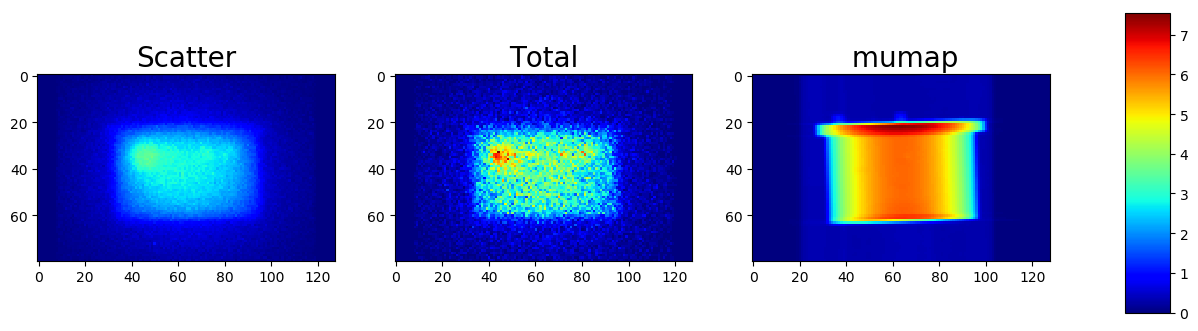

In [8]:
plot_projection1(k = 9)
### Question: need to use smooth scatter/total? 

In [9]:
def plot_projection2():
    """ Image Preview """
    k = 203 # look at kth image
    plt.style.use("default")
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 10))
    im1 = ax1.imshow(np.transpose(test_sca_nor[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(test_tot_nor[k,:,:,0]))
    ax1.set_title('Scatter',fontsize = 20)
#     cbar = fig.colorbar(im1, shrink=0.55, ax=ax1)
    im2 = ax2.imshow(np.transpose(test_tot_nor[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(test_tot_nor[k,:,:,0]))
    ax2.set_title('Total', fontsize = 20)
#     cbar = fig.colorbar(im2, shrink=0.55, ax=ax2)
    im3 = ax3.imshow(np.transpose(test_concat[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(test_concat[k,:,:,0]))
    ax3.set_title('mumap', fontsize = 20)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.3])
    fig.colorbar(im2, cax=cbar_ax)

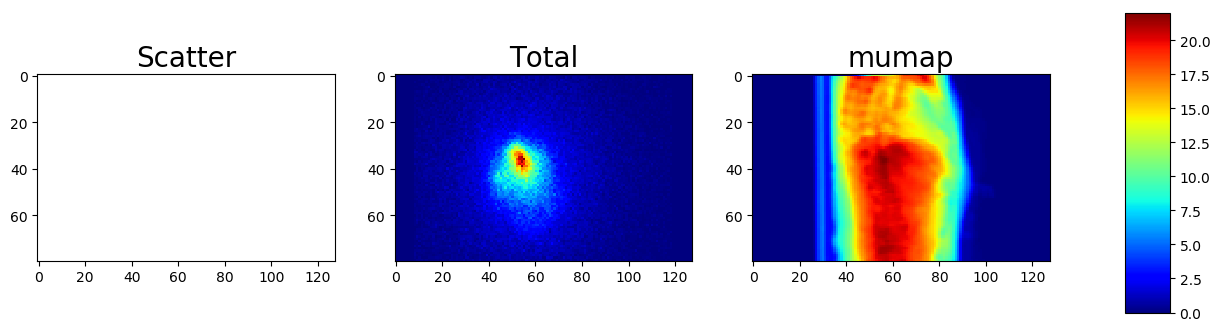

In [10]:
plot_projection2()

## Design Convolutional Neural Network

In [19]:
def get_net1():
    
    inputA = Input(shape=(Nx, Ny_mea, 1))
    
    convA1 = Conv2D(32, (3, 3), activation='relu', padding = 'same')(inputA)
    convA2 = Conv2D(64, (3, 3), activation='relu', padding = 'same')(convA1)
    convA3 = Conv2D(128, (3, 3), activation='relu', padding = 'same')(convA2)
    
    inputB = Input(shape=(Nx, Ny_mea, 1))
    convB1 = Conv2D(32, (3, 3), activation='relu', padding = 'same')(inputB)
    convB2 = Conv2D(64, (3, 3), activation='relu', padding = 'same')(convB1)
    convB3 = Conv2D(128, (3, 3), activation='relu', padding = 'same')(convB2)
    
    cat1 = concatenate([convA3, convB3])
    conv2 = Conv2D(128, (3, 3), activation='relu', padding = 'same')(cat1)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding = 'same')(conv2)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding = 'same')(conv3)
    conv5 = Dense(1, activation='relu')(conv4)
    
    model = Model(input=[inputA,inputB], output=conv5)
       
    model.compile(optimizer=Adam(lr=5e-5), loss='mse', metrics=['mae'])
    
    return model


In [20]:
model1 = get_net1()

/Users/xianghaowei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


## Check number of parameters

In [21]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 80, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 80, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 80, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 80, 32)  320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

## Train the CNN

In [22]:
# model_checkpoint1 = ModelCheckpoint('net0417.hdf5', monitor='loss',verbose=1, save_best_only=True)
EPOCHS = 100
history1 = model1.fit([training_tot_nor,training_mu_nor], training_sca_nor, validation_split=0.2, batch_size=32, epochs=EPOCHS, verbose=1, shuffle=True)

Train on 819 samples, validate on 205 samples
Epoch 1/100
819/819 [==============================] - 431s 526ms/step - loss: 0.7983 - mean_absolute_error: 0.4248 - val_loss: 0.1809 - val_mean_absolute_error: 0.2887
Epoch 2/100
819/819 [==============================] - 441s 538ms/step - loss: 0.0526 - mean_absolute_error: 0.1376 - val_loss: 0.0232 - val_mean_absolute_error: 0.0916
Epoch 3/100
819/819 [==============================] - 445s 543ms/step - loss: 0.0179 - mean_absolute_error: 0.0848 - val_loss: 0.0156 - val_mean_absolute_error: 0.0780
Epoch 4/100
819/819 [==============================] - 447s 546ms/step - loss: 0.0154 - mean_absolute_error: 0.0776 - val_loss: 0.0142 - val_mean_absolute_error: 0.0734
Epoch 5/100
819/819 [==============================] - 445s 543ms/step - loss: 0.0143 - mean_absolute_error: 0.0733 - val_loss: 0.0132 - val_mean_absolute_error: 0.0708
Epoch 6/100
819/819 [==============================] - 448s 547ms/step - loss: 0.0135 - mean_absolute_error: 

Epoch 49/100
819/819 [==============================] - 442s 539ms/step - loss: 0.0092 - mean_absolute_error: 0.0609 - val_loss: 0.0105 - val_mean_absolute_error: 0.0610
Epoch 50/100
819/819 [==============================] - 438s 535ms/step - loss: 0.0092 - mean_absolute_error: 0.0606 - val_loss: 0.0100 - val_mean_absolute_error: 0.0603
Epoch 51/100
819/819 [==============================] - 453s 553ms/step - loss: 0.0089 - mean_absolute_error: 0.0598 - val_loss: 0.0092 - val_mean_absolute_error: 0.0588
Epoch 52/100
819/819 [==============================] - 471s 575ms/step - loss: 0.0088 - mean_absolute_error: 0.0596 - val_loss: 0.0100 - val_mean_absolute_error: 0.0600
Epoch 53/100
819/819 [==============================] - 488s 596ms/step - loss: 0.0091 - mean_absolute_error: 0.0602 - val_loss: 0.0091 - val_mean_absolute_error: 0.0594
Epoch 54/100
819/819 [==============================] - 481s 587ms/step - loss: 0.0087 - mean_absolute_error: 0.0596 - val_loss: 0.0092 - val_mean_abs

## Save trained CNN structure and weights

In [19]:
# save trained model
from keras.utils import plot_model
plot_model(model1, to_file='model1.png',show_shapes = True,show_layer_names=True)
model1.save('DCNN_SC_v9.hdf5.h5')

## Load trained CNN structure and weights 

In [7]:
# load trained model
from keras.models import load_model
# EPOCHS = 100
model1 = load_model('DCNN_SC_v9.hdf5.h5')

## Test if CNN works in projection space 

In [27]:
def plot_mse():
    N_arr = np.arange(0, EPOCHS)
    plt.style.use("default")
    plt.figure()
    plt.plot(N_arr, np.sqrt(history1.history["loss"]), label="training")
    plt.plot(N_arr, np.sqrt(history1.history["val_loss"]), label="val")
    # plt.plot(N_arr, history1.history["mean_absolute_error"], label="train_MAE")
    # plt.plot(N_arr, history1.history["val_mean_absolute_error"], label="val_MAE")
    plt.title("Mean Square Error")
    plt.xlabel("Epoch #")
    plt.ylabel("MSE")
    plt.legend()

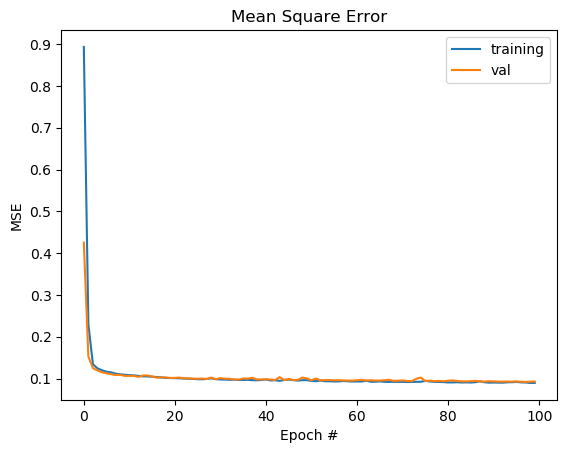

In [28]:
plot_mse()
plt.savefig('mse_0112.eps', format='eps')

In [8]:
s1 = model1.predict([training_tot_nor,training_mu_nor])
score1 = model1.evaluate([training_tot_nor,training_mu_nor], training_sca_nor)
print(s1.shape)

1024/1024 [==============================] - 173s 169ms/step
(1024, 128, 80, 1)


In [69]:
nrmse_training = np.sqrt(score1[0]/(np.sum(training_sca_nor**2)/training_sca_nor.size))

# print("training MSE:" , score1[0])
print('previous training NRMSE: 0.08059985685863975')
print("now training NRMSE:" , nrmse_training)

previous training NRMSE: 0.08059985685863975
now training NRMSE: 0.07433791292508206


In [71]:
def plot_training():
    k = 260 # look at kth image
    plt.style.use("default")
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 10))
    im1 = ax1.imshow(np.transpose(training_sca_nor[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(training_tot_nor[k,:,:,0]))
    ax1.set_title('Scatter by SIMIND',fontsize = 20)
#     cbar = fig.colorbar(im1, shrink=0.4, ax=ax1)
    im2 = ax2.imshow(np.transpose(s1[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(training_tot_nor[k,:,:,0]))
    ax2.set_title('Estimation by CNN', fontsize = 20)
#     cbar = fig.colorbar(im2, shrink=0.4, ax=ax2)
    im3 = ax3.imshow(np.transpose(training_tot_nor[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(training_tot_nor[k,:,:,0]))
    ax3.set_title('Total by SIMIND', fontsize = 20)
#     cbar = fig.colorbar(im2, shrink=0.4, ax=ax3)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.3])
    fig.colorbar(im3, cax=cbar_ax)

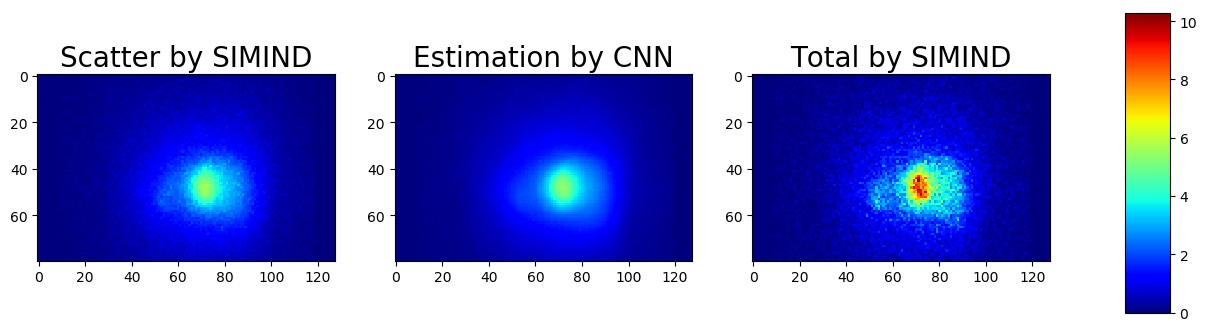

In [73]:
### training data
plot_training()

In [9]:
def plot_profile():
    # plt.figure()
    # np.mean(training_sca_nor[k,75:85,:,0], axis = 0).shape
    
    plt.plot(range(Nx),np.mean(training_sca_nor[k,:,40:50,0], axis = 1), label="true scatter")
    plt.plot(np.mean(s1[k,:,40:50,0], axis = 1), label="estimated scatter")
#     plt.plot(np.mean(res_s1[k,:,40:50,0], axis = 1), label="estimated res scatter")
    plt.plot(np.mean(training_sca_nor[k,:,40:50,0]- s1[k,:,40:50,0], axis = 1), label="scatter error")

    plt.title("training")
    plt.xlabel("profile")
    plt.ylabel("activity")
    plt.legend()

In [12]:
tmp1 = np.mean(training_sca_nor[k,:,40:50,0], axis = 1)
tmp2 = np.mean(s1[k,:,40:50,0], axis = 1)
np.save('true_profile',tmp1)
np.save('training_profile',tmp2)

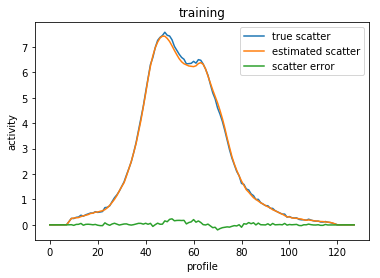

In [10]:
plot_profile()

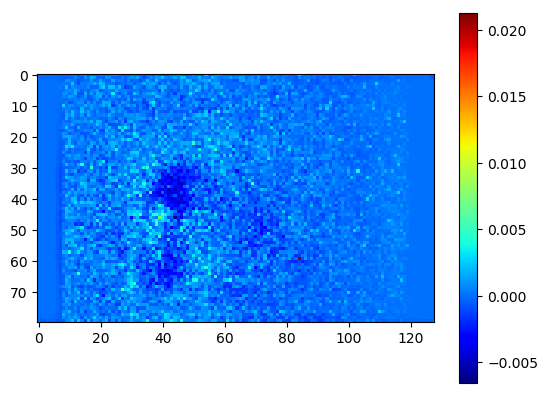

In [105]:
im3 = plt.imshow(np.transpose(training_sca_nor[k,:,:,0] - s1[k,:,:,0]), cmap = 'jet')
cbar = plt.colorbar(im3)

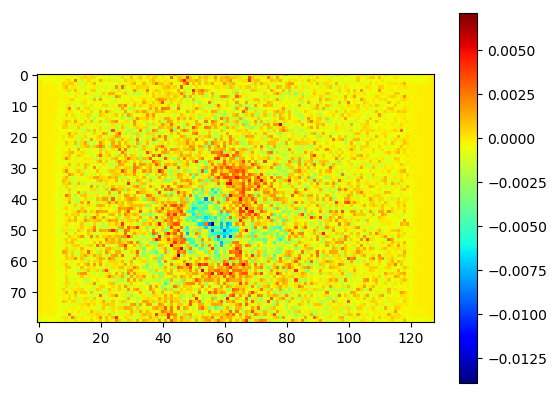

In [122]:
im3 = plt.imshow(np.transpose(training_sca_nor[k,:,:,0] - res_s1[k,:,:,0]), cmap = 'jet')
cbar = plt.colorbar(im3)

In [19]:
s2 = model1.predict([test_tot_nor,test_mu_nor])
score2 = model1.evaluate([test_tot_nor,test_mu_nor], test_sca_nor)
print(s2.shape)
# print(np.max(test_sca_nor[:,:,:1]))

1024/1024 [==============================] - 1608s 2s/step
(1024, 128, 80, 1)


(1024, 128, 80, 1)
7.048118808633727
8000000.0000000065


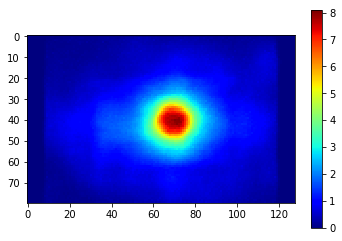

In [20]:
print(test_sca_nor.shape)
print(np.max(test_sca_nor[0,:,:,:]))
im = plt.imshow(np.transpose(s2[1,:,:,0]), cmap = 'jet')
cbar = plt.colorbar(im)
print(np.sum(test_tot_nor))

In [178]:
nrmse_test = np.sqrt(score2[0]/(np.sum(test_sca_nor**2)/test_sca_nor.size))

print("test MSD (compare to SIMIND):" , score2[0])
print("test NRMSD (compare to SIMIND):" , nrmse_test)

test MSD (compare to SIMIND): 2.085312470651641e-06
test NRMSD (compare to SIMIND): 0.1376282841053033


## Reshape CNN outpout to the sactter estimation for futher recon 
    Final output is named as 'sca_cnn'

In [21]:
sca_cnn = np.squeeze(np.transpose(s2,[1,2,0,3]))
# sca_res_cnn = np.squeeze(np.transpose(res_s2,[1,2,0,3]))
sca_cnn = np.reshape(sca_cnn,[Nx,Ny_mea,Np,test_sca.shape[3]])
# sca_res_cnn = np.reshape(sca_res_cnn,[Nx,Ny_mea,Np,test_sca.shape[3]])
sca_sim = np.squeeze(np.transpose(test_sca_nor,[1,2,0,3]))
sca_sim = np.reshape(sca_sim,[Nx,Ny_mea,Np,test_sca.shape[3]])

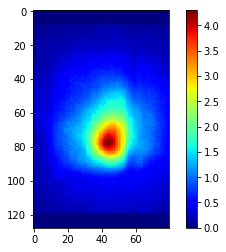

In [28]:
im = plt.imshow(sca_cnn[:,:,50,0], cmap = 'jet')
cbar = plt.colorbar(im) # 53412 12367

In [30]:
p = 2
sca_nema = sca_cnn[:,:,:,p] / SCALE_CONSTANT * np.sum(test_tot[:,:,:,p])
sio.savemat('shell2_totmu_pred_v9_0101',dict([('prediction', sca_nema)]))

In [15]:
sca_cnn_training = np.squeeze(np.transpose(s1,[1,2,0,3]))
sca_cnn_training = np.reshape(sca_cnn_training,[Nx,Ny_mea,Np,training_sca.shape[3]])

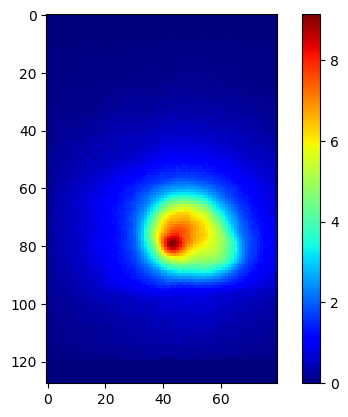

In [16]:
im = plt.imshow(sca_cnn_training[:,:,50,0], cmap = 'jet')
cbar = plt.colorbar(im) # 53412 12367

In [223]:
p = 3
sca_shell = sca_cnn[:,:,:,p] / SCALE_CONSTANT * np.sum(test_tot[:,:,:,p])
# sio.savemat('shell_totmu_pred_0723',dict([('prediction', sca_shell)]))

In [199]:
p = 7
sca_nema = sca_cnn[:,:,:,p] / SCALE_CONSTANT * np.sum(test_tot[:,:,:,p])
sio.savemat('nema_real2_totmu_pred_0719',dict([('prediction', sca_nema)]))

In [141]:
p = 0
dif = sca_cnn[:,:,:,p]-sca_sim[:,:,:,p]
dif_res = sca_res_cnn[:,:,:,p]-sca_sim[:,:,:,p]
rmsd = np.sqrt(np.sum((dif)**2)/(Nx*Ny_mea*Np))
rmsd_res = np.sqrt(np.sum((dif_res)**2)/(Nx*Ny_mea*Np))
# print('Nema Phantom RMSE: ',rmsd)
nrmsd = rmsd/np.sqrt(np.mean(sca_cnn[:,:,:,p]**2))
nrmsd_res = rmsd/np.sqrt(np.mean(sca_res_cnn[:,:,:,p]**2))
# print('Previous Nema Phantom NRMSE:  0.15616654355296813')
print('Nema Phantom NRMSE: ',nrmsd)
print('Res Nema Phantom NRMSE: ',nrmsd_res)
# print('sum of test_tot[:,:,:,p]:',np.sum(test_tot[:,:,:,p]))
# print('sum of sca_cnn[:,:,:,p]:',np.sum(sca_cnn[:,:,:,p]))
sca_nema = sca_cnn[:,:,:,p] / SCALE_CONSTANT * np.sum(test_tot[:,:,:,p])
# print('sum of sca_nema[:,:,:,p]:',np.sum(sca_nema))
sio.savemat('liver_mea_totmu_pred_0430',dict([('prediction', sca_nema)]))

Nema Phantom NRMSE:  0.14589273782615644
Res Nema Phantom NRMSE:  0.13883461538004527


### Misc

In [142]:
p = 1
dif = sca_cnn[:,:,:,p]-sca_sim[:,:,:,p]
dif_res = sca_res_cnn[:,:,:,p]-sca_sim[:,:,:,p]
rmsd = np.sqrt(np.sum((dif)**2)/(Nx*Ny_mea*Np))
rmsd_res = np.sqrt(np.sum((dif_res)**2)/(Nx*Ny_mea*Np))
# print('liver Phantom RMSD: ',rmsd)
nrmsd = rmsd/np.sqrt(np.mean(sca_cnn[:,:,:,p]**2))
nrmsd_res = rmsd/np.sqrt(np.mean(sca_res_cnn[:,:,:,p]**2))
print('liver Phantom NRMSD: ',nrmsd)
print('Res liver Phantom NRMSE: ',nrmsd_res)
sca_ab2 = sca_cnn[:,:,:,p] / SCALE_CONSTANT * np.sum(test_tot[:,:,:,p])
# sio.savemat('liver_totmu_pred_0423',dict([('prediction', sca_ab2)]))

liver Phantom NRMSD:  0.06569834146146991
Res liver Phantom NRMSE:  0.06327274631419554


In [159]:
p = 3
dif = sca_cnn[:,:,:,p]-sca_sim[:,:,:,p]
dif_res = sca_res_cnn[:,:,:,p]-sca_sim[:,:,:,p]
rmsd = np.sqrt(np.sum((dif)**2)/(Nx*Ny_mea*Np))
rmsd_res = np.sqrt(np.sum((dif_res)**2)/(Nx*Ny_mea*Np))
# print('liver Phantom RMSD: ',rmsd)
nrmsd = rmsd/np.sqrt(np.mean(sca_cnn[:,:,:,p]**2))
nrmsd_res = rmsd/np.sqrt(np.mean(sca_res_cnn[:,:,:,p]**2))
print('ab2 Phantom NRMSD: ',nrmsd)
print('res ab2 Phantom NRMSD: ',nrmsd_res)
sca_ab2 = sca_cnn[:,:,:,p] / SCALE_CONSTANT * np.sum(test_tot[:,:,:,p])
# sio.savemat('ab2_totmu_pred_0423',dict([('prediction', sca_ab2)]))

ab2 Phantom NRMSD:  0.30246479302206064
res ab2 Phantom NRMSD:  0.28943433667521085


In [142]:
def plot_testing(k = 100):
#     k = 150 # look at kth image
    plt.style.use("default")
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 10))
    im1 = ax1.imshow(np.transpose(test_sca_nor[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(test_tot_nor[k,:,:,0]))
    ax1.set_title('SIMIND scatter estimation',fontsize = 20)
#     cbar = fig.colorbar(im1, shrink=0.4, ax=ax1)
    im2 = ax2.imshow(np.transpose(s2[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(test_tot_nor[k,:,:,0]))
    ax2.set_title('CNN scatter estimation', fontsize = 20)
#     cbar = fig.colorbar(im2, shrink=0.4, ax=ax2)
    im3 = ax3.imshow(np.transpose(test_tot_nor[k,:,:,0]), cmap = 'jet', vmin = 0, vmax = np.max(test_tot_nor[k,:,:,0]))
    ax3.set_title('Total with Poisson Noise', fontsize = 20)
#     cbar = fig.colorbar(im3, shrink=0.4, ax=ax3)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.3])
    fig.colorbar(im3, cax=cbar_ax)

In [152]:
sum1 = np.sum(test_sca_nor[384:,:,:,0])
print('MC scatter counts: ',sum1)
sum2 = np.sum(s2[384:,:,:,0])
print('CNN scatter counts: ', sum2)

MC scatter counts:  8994.98350350755
CNN scatter counts:  9095.287


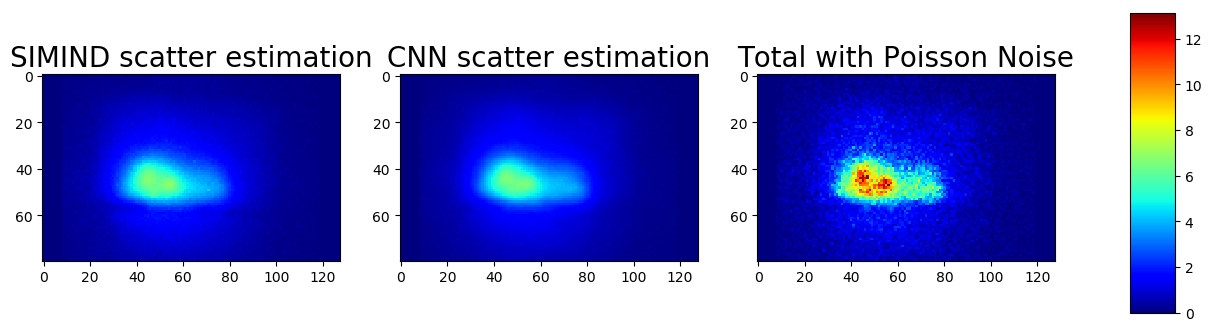

In [146]:
### testing data on 20% of ab,ab2,liver phantom
plot_testing(k = 3)

In [93]:
def plot_mse():
    N_arr = np.arange(0, EPOCHS)
    plt.style.use("default")
    plt.figure()
    plt.plot(N_arr, np.sqrt(history1.history["loss"]), label="train")
    plt.plot(N_arr, np.sqrt(history1.history["val_loss"]), label="val")
    # plt.plot(N_arr, history1.history["mean_absolute_error"], label="train_MAE")
    # plt.plot(N_arr, history1.history["val_mean_absolute_error"], label="val_MAE")
    plt.title("Mean Square Error")
    plt.xlabel("Epoch #")
    plt.ylabel("MSE")
    plt.legend()

In [222]:
def plot_tmp(k = 0):
    f = plt.figure(figsize=(14,6))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    N_arr = np.arange(0, EPOCHS)
    ax.plot(N_arr, np.sqrt(history1.history["loss"]), label="train")
    ax.plot(N_arr, np.sqrt(history1.history["val_loss"]), label="val")
    # plt.plot(N_arr, history1.history["mean_absolute_error"], label="train_MAE")
    # plt.plot(N_arr, history1.history["val_mean_absolute_error"], label="val_MAE")
    ax.set_title("Mean Square Error",fontsize=20)
    ax.set_xlabel("Epoch #",fontsize=20)
    ax.set_ylabel("MSE",fontsize=20)
    ax.legend(loc=1, prop={'size': 20})
    ax.grid(True)
#     k = 150 # look at kth image
#     ax2.style.use("default")
    ax2.plot(range(Nx),np.mean(test_sca_nor[k,:,42:44,:],axis = 1), label="True scatter estimation")
    ax2.plot(np.mean(s2[k,:,42:44,:],axis = 1), label="CNN scatter estimation")
    ax2.set_title("profile",fontsize=20)
    ax2.set_xlabel("pixels",fontsize=20)
    ax2.set_ylabel("activity",fontsize=20)
    ax2.legend(loc=2, prop={'size': 12})
    ax2.grid(True)
    plt.savefig('train_mse_profile.eps', format='eps')

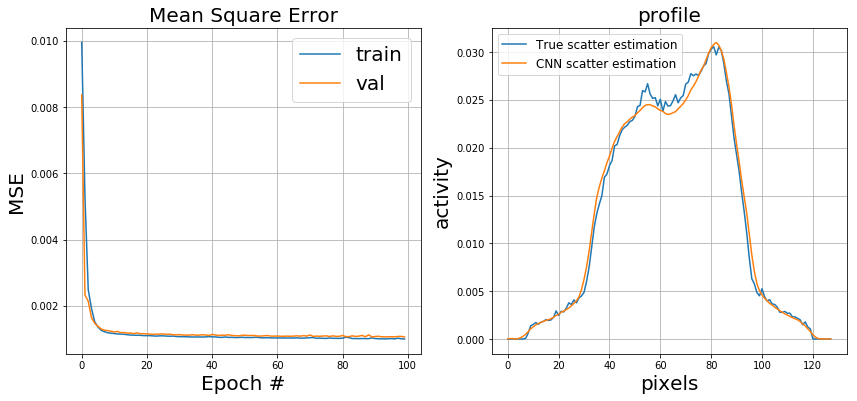

In [223]:
plot_tmp(k = 1)

In [106]:
def plot_profile2(k = 50):
    plt.figure()
#     k = 480
    plt.plot(range(Nx),np.mean(test_sca_nor[k,:,42:44,:],axis = 1), label="SIMIND scatter estimation")
    plt.plot(np.mean(s2[k,:,42:44,:],axis = 1), label="CNN scatter estimation")
#     plt.plot(np.mean(test_sca_nor[k,63:65,:,:]-s2[k,63:65,:,:],axis = 0), label="scatter error")
#     dif = s2[k,:,:,63:65]-test_sca_nor[k,:,:,63:65]
#     rmsd = np.sqrt(np.sum((dif)**2)/(Nx*Ny_mea))
#     nrmsd = rmsd/np.sqrt(np.sum(s2[k,:,:,0]**2)/(Nx*Ny_mea))
    plt.title("profile")
    plt.xlabel("profile")
    plt.ylabel("activity")
    plt.legend()
    print("profile NRMSD:", nrmsd)

profile NRMSD: 0.30246479302206064


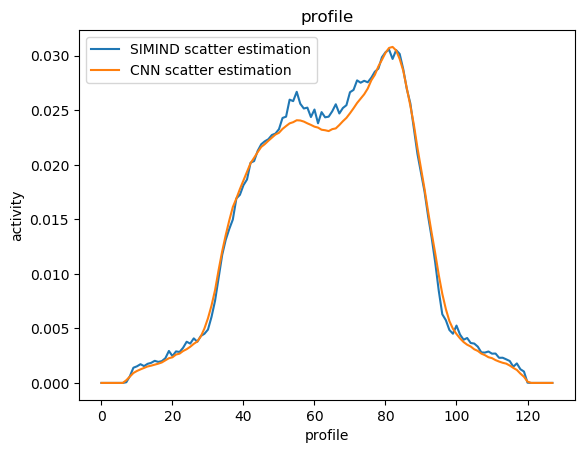

In [107]:
plot_profile2(k = 0)